In [1]:
import math
import random
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def sin_wave(A, omega, fai, length):
	# A*sin(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.sin(x - fai)
def cos_wave(A, omega, fai, length):
	# A*cos(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.cos(x - fai)

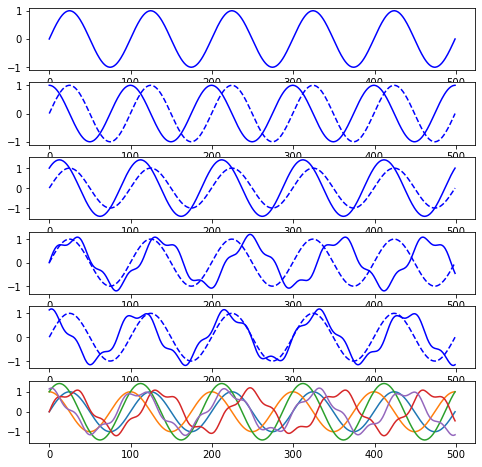

In [3]:
x1 = sin_wave(1, 100, 0, 500)
x2 = cos_wave(1, 100, 0, 500)
x3 = sin_wave(1, 100, 0, 500) + cos_wave(1, 100, 0, 500)
x4 = sin_wave(1, 110, 0, 500) + sin_wave(0.2, 30, 0, 500)
x5 = cos_wave(1, 110, 0, 500) + sin_wave(0.2, 30, -np.pi/4, 500)
X = np.array([x1,x2,x3,x4,x5]).T

plt.figure(figsize=(8,8))
plt.subplot(611)
plt.plot(x1,color='b')
plt.subplot(612)
plt.plot(x2,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(613)
plt.plot(x3,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(614)
plt.plot(x4,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(615)
plt.plot(x5,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(616)
plt.plot(X)

In [4]:
def missing_matrix(X, missing_len=0.05, missing_num=10):
	#連続した欠損値を生成する
	#X = (Time, dim)
	#missing_len 全体の長さ(Time)のうちどれだけの割合を欠損値にするか
	#missing_num 欠損値の数
	#W: if X[i,j] == nan then W[i,j] == 0 else W[i,j] == 1

	W = np.ones(X.shape)
	(r, l) = X.shape
	#missing_point[[row, startpoint, length],[],...]
	missing_points = [[random.randint(0,l-1), random.randint(0,r-1), random.randint(0,int(r*missing_len))] for i in range(missing_num)]

	for point in missing_points:
		if point[1]+point[2]>=r:
			end=r-1
		else:
			end=point[1]+point[2]
		W[point[1]:end, point[0]] = 0
	return W

def to_missing_X(X, W):
	W_nan = copy.copy(W)
	W_nan[W_nan==0]=np.nan
	missing_X = X * W_nan
	return missing_X

def interpolate_matrix(X, how):
	#線形補完
	initial_X = pd.DataFrame(X).interpolate(method=how)
	#最後にnanがあるなら直前の値で埋める
	initial_X = initial_X.fillna(method='ffill')
	#最初にnanがあるなら直後の値で埋める
	initial_X = initial_X.fillna(method='bfill')
	return np.array(initial_X)


number of missing value 521


<AxesSubplot:>

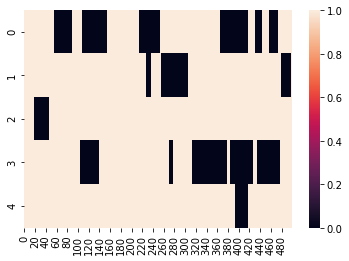

In [5]:
W = missing_matrix(X, missing_len=0.1, missing_num=20)
missing_X = to_missing_X(X, W)
linear_X = interpolate_matrix(missing_X, how='linear')
initial_X = copy.copy(linear_X)

print('number of missing value', np.count_nonzero(np.isnan(missing_X)))
#missing values are black
sns.heatmap(W.T)

In [6]:
from scipy.linalg import lu
def logdet(A, cholesky=True):
	# np.log(np.linalg.det(A))

	#cholesky分解はLU分解の高速ver
	if cholesky:
		v = 2 * sum(np.log(np.diag(np.linalg.cholesky(A)))) 
	#LU分解
	else:
		P, L, U = lu(A)
		du = np.diag(U)
		c = np.linalg.det(P) * np.prod(np.sign(du))
		v = np.log(c) + sum(np.log(abs(du)))
	return v

def efficient_woodbury(A, U, V, D):
    A_inv_diag = 1./np.diag(A)  # note! A_inv_diag is a vector!
    B_inv = np.linalg.inv(D + (V * A_inv_diag) @ U)
    return np.diag(A_inv_diag) - (A_inv_diag.reshape(-1,1) * U @ B_inv @ V * A_inv_diag)

class LDS(object):
	def __init__(self, X, n_dim_state=6):
		#X = (Time, dim)
		self.N = X.shape[0]
		self.M = X.shape[1]
		#hidden state
		self.H = n_dim_state

		#transition matrix (F)
		self.A = np.eye(self.H, self.H) + np.random.randn(self.H, self.H)
		#observation matrix (G)
		self.C = np.eye(self.M, self.H) + np.random.randn(self.M, self.H)
		#transition covariance (Lambda)
		self.Q = np.eye(self.H, self.H)
		#observation covariance (Sigma)
		self.R = np.eye(self.M, self.M)
		#initial hidden state
		self.mu0 = np.random.randn(self.H)
		#Gamma
		self.Q0 = self.Q
		

	def forward(self, X):
		#X = (Time, dim)
		N = self.N
		H = self.H
		Ih = np.eye(H, H)
		LOGLI=False
		# FAST=False
		FAST=True #Woodbury formula
		EFFICIENT=True #use only diagonal

		mu = [[]for _ in range(N)]
		V = [[]for _ in range(N)]
		P = [[]for _ in range(N)]

		logli = 0

		if FAST:
			if EFFICIENT:
				R_inv_diag = 1./np.diag(self.R)
			else:
				R_inv = np.diag(1./np.diag(self.R))


		for i in range(N):
			if i == 0:
				#Initialize
				KP = self.Q0 
				mu[i] =  self.mu0
			else :
				#F@V@F.T + Lambda
				P[i-1] = self.A @ V[i-1] @ self.A.T + self.Q
				KP = P[i-1]
				#F@mu
				mu[i] =  self.A @ mu[i-1]

			if FAST:
				if EFFICIENT:
					KP_inv = np.linalg.pinv(np.linalg.inv(KP) + (self.C.T * R_inv_diag) @ self.C)
					invSig = np.diag(R_inv_diag) - (R_inv_diag.reshape(-1,1) * self.C @ KP_inv @ self.C.T * R_inv_diag)
				else:
					KP_inv = np.linalg.pinv(np.linalg.inv(KP) + self.C.T @ R_inv @ self.C)
					invSig = R_inv - (R_inv @ self.C @ KP_inv @ self.C.T @ R_inv)
			else:
				#G@Delta@G.T + Sigma
				sigma = self.C @ KP @ self.C.T + self.R
				invSig = np.linalg.pinv(sigma)

			#P@G.T@invSig
			K = KP @ self.C.T @ invSig
			#G@mu  mean of c
			u_c = self.C @ mu[i]
			delta = X[i] - u_c
			#F@mu + K@delta
			mu[i] = mu[i] + K @ delta
			#(I - K)@P
			V[i] = (Ih - K @ self.C) @ KP
			# V[i] = (Ih - K) @ KP

			if (LOGLI):
				posDef = delta.T @ invSig @ delta / 2
				if (posDef < 0):
					print('det of not positive definite < 0')
				logli = logli - self.M/2 * np.log(2 * np.pi) + logdet(invSig, cholesky=False) / 2 - posDef

		self.mu = mu
		self.V = V
		self.P = P
		return mu, V, P

	def backward(self, mu, V, P):
		N = self.N
		Ez = [[] for _ in range(N)]
		Ezz = [[] for _ in range(N)]
		Ez1z = [[] for _ in range(N)]
		Ez[-1] = mu[-1]
		Vhat = V[-1]
		# Ezz[-1] = Vhat + np.outer(Ez[-1], Ez[-1].T)
		Ezz[-1] = Vhat + np.outer(Ez[-1], Ez[-1])

		for i in reversed(range(N-1)):
			#J = V @ F.T @ inv(P)
			J = V[i] @ self.A.T @ np.linalg.pinv(P[i])
			#Ez = mu^ = mu + J@(mu^ - F@mu)
			Ez[i] = mu[i] + J @ (Ez[i+1] - self.A @ mu[i])
			#Ez1z = J@V^ + mu^@1mu^
			Ez1z[i] = Vhat @ J.T + np.outer(Ez[i+1], Ez[i])
			#V^ = V + J@(V^ - P)@J.T
			Vhat = V[i] + J @ (Vhat - P[i]) @ J.T
			#Ezz = V^ + mu^@mu^.T
			Ezz[i] = Vhat + np.outer(Ez[i], Ez[i])

		self.Ez = Ez
		self.Ezz = Ezz
		self.Ez1z = Ez1z
		return Ez, Ezz, Ez1z

	def MLE_lds(self, X, Ez, Ezz, Ez1z):
		LEARNA = True
		LEARNQ = True
		LEARNC = True
		LEARNR = True
		LEARNMU0 = True
		LEARNQ0 = True

		Full=False

		#X = (Time, dim)
		N = self.N
		M = self.M
		H = self.H
		Sz1z = np.zeros((H, H))
		Szz = np.zeros((H, H))
		Sxz = np.zeros((M, H))

		for i in range(N-1):
			#ΣEz1z
			Sz1z = Sz1z + Ez1z[i]

		for i in range(N):
			#ΣEzz
			Szz = Szz + Ezz[i]
			#Σx@Ez.T
			Sxz = Sxz + np.outer(X[i], Ez[i])

		#ΣEzz
		SzzN = Szz - Ezz[-1]

		if LEARNMU0:
			self.mu0 = Ez[0]

		if LEARNQ0:
			self.Q0 = Ezz[0] - np.outer(Ez[0], Ez[0])
			if Full:
				pass
			else:
				self.Q0 = np.diag(np.diag(self.Q0))

		if LEARNA: #F
			self.A = Sz1z @ np.linalg.pinv(SzzN)

		if LEARNQ: #Lambda
			if Full:
				tmp = self.A @ Sz1z.T
				self.Q = (Szz - Ezz[0] - tmp - tmp.T + self.A @ SzzN @ self.A.T) / (N-1)
			else:
				self.Q = np.diag(Szz) - np.diag(Ezz[0])
				self.Q -= 2 * np.diag(self.A @ Sz1z.T)
				self.Q += np.diag(self.A @ SzzN @ self.A.T)
				self.Q = np.diag(self.Q / (N-1))

		if LEARNC: #G
			self.C = Sxz @ np.linalg.pinv(Szz)

		if LEARNR: #Sigma
			if Full:
				tmp = self.C @ Sxz.T
				self.R = (X.T @ X - tmp - tmp.T + self.C @ Szz @ self.C.T) / N
			else:
				self.R = np.diag((np.diag(X.T @ X) - 2 * np.diag(self.C @ Sxz.T) + np.diag(self.C @ Szz @ self.C.T)) / N)
	
	def em(self, X, n_iter=100):
		for _ in range(n_iter):
			mu, V, P = self.forward(X)
			Ez, Ezz, Ez1z = self.backward(mu, V, P)
			self.MLE_lds(X, Ez, Ezz, Ez1z)



In [7]:
def isTiny(sigma):
	eps = 1.0e-10
	return (np.linalg.norm(sigma,1) < eps) or (np.any(np.diag(sigma) < eps))


def DynaMMo(X, W, n_dim_state, n_iter=100):
	lds = LDS(X, n_dim_state)
	for n in range(n_iter):
		lds.em(X, n_iter=1)

		N = lds.N
		Y = np.empty((lds.N, lds.M))
		for i in range(N):
			Y[i] = lds.C @ lds.Ez[i]
			for j in range(lds.M):
				if W[i,j]==0:
					X[i,j] = Y[i,j]

		if (isTiny(lds.Q0) or isTiny(lds.Q) or isTiny(lds.R)):
			print('converged at n_iter=',n)
			break
		if n==n_iter-1:
			print('not converged until n_iter=',n_iter)
	return X


In [8]:
dynammo_X = DynaMMo(initial_X, W, n_dim_state=9, n_iter=200)

not converged until n_iter= 200


<AxesSubplot:>

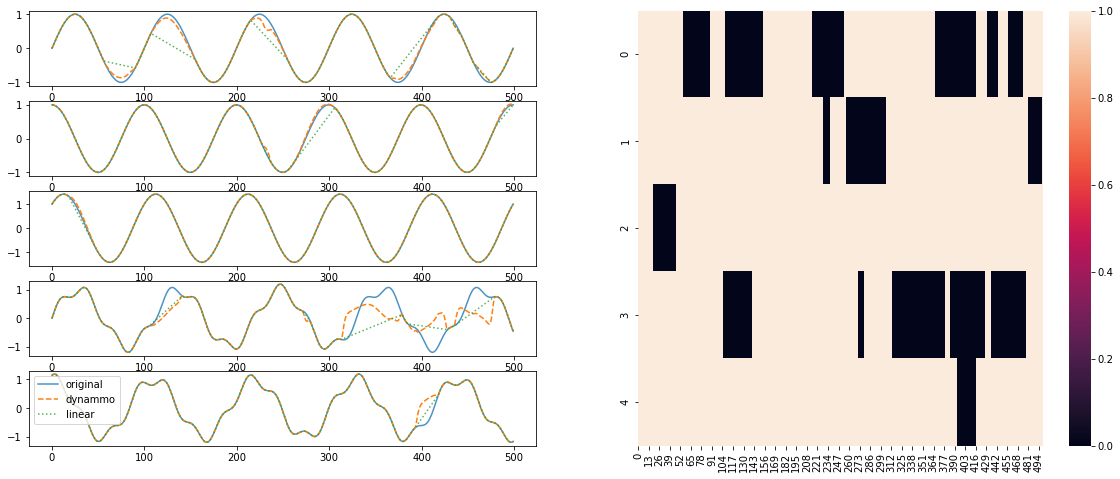

In [9]:
ori_alpha=0.8
sp_alpha=0.8
plt.figure(figsize=(20,8))
plt.subplot(521)
plt.plot(x1, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,0], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,0], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(523)
plt.plot(x2, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,1], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,1], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(525)
plt.plot(x3, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,2], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,2], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(527)
plt.plot(x4, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,3], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,3], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(529)
plt.plot(x5, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,4], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,4], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.legend()
plt.subplot(122)
sns.heatmap(W.T)